# Prepare ground truth built by matching with the results of CNMF

User guide 

Version:   2.0

Copyright: GNU General Public License v2.0

Created on Mon Nov 21 2016, updated on Thu Jan 09 2025

Authors: agiovann, mpaez

### Load Up the Libraries

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.base.rois import extract_binary_masks_blob
from caiman.components_evaluation import estimate_components_quality, evaluate_components
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise 
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.tests.comparison import comparison
from caiman.utils.visualization import plot_contours, view_patches_bar

2025-02-26 18:34:36.841036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 18:34:36.853685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 18:34:36.857296: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 18:34:36.866408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740612876.881571 2499908 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740612876.88

### Loading up the Ground Truth Files 

In [2]:
# neurofinder.03.00.test
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.03.00.test/images/final_map/Yr_d1_498_d2_467_d3_1_order_C_frames_2250_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.03.00.test/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                #                 'r_values_min_patch': .7,  # threshold on space consistency
                #                 'fitness_min_patch': -20,  # threshold on time variability
                #                 # threshold on time variability (if nonsparse activity)
                #                 'fitness_delta_min_patch': -20,
                #                 'Npeaks': 10,
                #                 'r_values_min_full': .8,
                #                 'fitness_min_full': - 40,
                #                 'fitness_delta_min_full': - 40,
                #                 'only_init_patch': True,
                'gnb': 1,
                #                 'memory_fact': 1,
                #                 'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False  # for some movies needed
                }

# neurofinder.04.00.test
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.04.00.test/images/final_mapYr_d1_512_d2_512_d3_1_order_C_frames_3000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.04.00.test/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                #                 'r_values_min_patch': .7,  # threshold on space consistency
                #                 'fitness_min_patch': -20,  # threshold on time variability
                #                 # threshold on time variability (if nonsparse activity)
                #                 'fitness_delta_min_patch': -20,
                #                 'Npeaks': 10,
                #                 'r_values_min_full': .8,
                #                 'fitness_min_full': - 40,
                #                 'fitness_delta_min_full': - 40,
                #                 'only_init_patch': True,
                'gnb': 1,
                #                 'memory_fact': 1,
                #                 'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False  # for some movies needed

                }

# Yi not clear neurons
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/Yi.data.001/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_7826_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/Yi.data.001/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 30,
                #                 'r_values_min_patch': .7,  # threshold on space consistency
                #                 'fitness_min_patch': -20,  # threshold on time variability
                #                 # threshold on time variability (if nonsparse activity)
                #                 'fitness_delta_min_patch': -20,
                #                 'Npeaks': 10,
                #                 'r_values_min_full': .8,
                #                 'fitness_min_full': - 40,
                #                 'fitness_delta_min_full': - 40,
                #                 'only_init_patch': True,
                'gnb': 1,
                #                 'memory_fact': 1,
                #                 'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                }

# neurofinder.02.00
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.02.00/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_8000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.02.00/regions/joined_consensus_active_regions.npy'],
                'merge_thresh': .8,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                                     #(to be used with one background per patch)
                'swap_dim': False  # for some movies needed
                }

# yuste: used kernel = np.ones((radius//4,radius//4),np.uint8)
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/yuste.Single_150u/images/final_map/Yr_d1_200_d2_256_d3_1_order_C_frames_3000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/yuste.Single_150u/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False  # for some movies needed
                }

# neurofinder 00 00
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.00.00/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_2936_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.00.00/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                #                 'r_values_min_patch': .7,  # threshold on space consistency
                #                 'fitness_min_patch': -20,  # threshold on time variability
                #                 # threshold on time variability (if nonsparse activity)
                #                 'fitness_delta_min_patch': -20,
                #                 'Npeaks': 10,
                #                 'r_values_min_full': .8,
                #                 'fitness_min_full': - 40,
                #                 'fitness_delta_min_full': - 40,
                #                 'only_init_patch': True,
                'gnb': 1,
                #                 'memory_fact': 1,
                #                 'n_chunks': 10,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False  # for some movies needed
                }

# k53
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/k53_20160530/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_116043_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/k53_20160530/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/k53_20160530/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 30,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None
                }

# neurofinder: 01.01
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.01.01/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_1825_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.01.01/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/neurofinder.01.01/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None
                }

# J115: 01.01
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/J115_2015-12-09_L01_ELS/images/final_map/Yr_d1_463_d2_472_d3_1_order_C_frames_90000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/J115_2015-12-09_L01_ELS/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/J115_2015-12-09_L01_ELS/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None
                }

# J123
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/J123_2015-11-20_L01_0/images/final_map/Yr_d1_458_d2_477_d3_1_order_C_frames_41000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/J123_2015-11-20_L01_0/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/J123_2015-11-20_L01_0/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None
                }
# Jan-AMG
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/Jan-AMG_exp3_001/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_115897_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/Jan-AMG_exp3_001/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/Jan-AMG_exp3_001/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 10,
                'gnb': 1,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None,
                'crop_pix': 8,
                }

# sue k37, not nice because few events
params_movie = {'fname': ['/mnt/ceph/data/neuro/caiman/labeling/k37_20160109_AM_150um_65mW_zoom2p2_00001_1-16/images/final_map/Yr_d1_512_d2_512_d3_1_order_C_frames_48000_.mmap'],
                'gtname': ['/mnt/ceph/data/neuro/caiman/labeling/k37_20160109_AM_150um_65mW_zoom2p2_00001_1-16/regions/joined_consensus_active_regions.npy'],
                'seed_name': ['/mnt/ceph/data/neuro/caiman/labeling/k37_20160109_AM_150um_65mW_zoom2p2_00001_1-16/regions/joined_consensus_active_regions.npy'],
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 1,  # merging threshold, max correlation allow
                'final_frate': 30,
                'gnb': 2,
                # whether to update the background components in the spatial phase
                'update_background_components': True,
                'low_rank_background': True,  # whether to update the using a low rank approximation. In the False case all the nonzero elements of the background components are updated using hals
                #(to be used with one background per patch)
                'swap_dim': False,  # for some movies needed
                'kernel': None,
                'crop_pix': 7,
                }

### Parameters for the Movie

In [3]:
params_display = {
    'downsample_ratio': .2,
    'thr_plot': 0.8
}

# fname_new: name of the movie
fname_new = params_movie['fname'][0]

### Run Analysis

In [4]:
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# fname_new='Yr_d1_501_d2_398_d3_1_order_F_frames_369_.mmap'
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')
m_images = cm.movie(images)

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
/mnt/home/mpaez/miniforge3/envs/caiman_pytorch/lib/python3.12/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
/mnt/home/mpaez/miniforge3/envs/caiman_pytorch/lib/python3.12/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
/mnt/home/mpaez/miniforge3/envs/caiman_pytorch/lib/python3.12/site-

### Correlation Image

Your tif file is saved a single pagefile. Performance will be affected


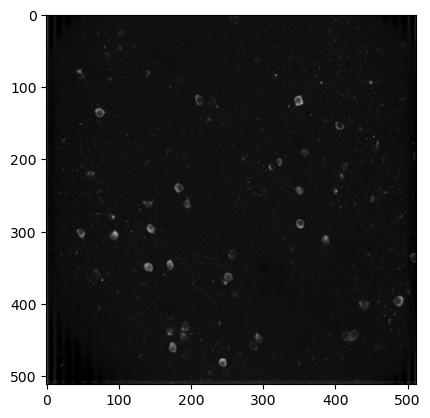

In [5]:
if m_images.shape[0] < 10000:
    Cn = m_images.local_correlations(
        swap_dim=params_movie['swap_dim'], frames_per_chunk=1500)
    Cn[np.isnan(Cn)] = 0
else:
    Cn = np.array(cm.load(('/'.join(params_movie['gtname'][0].split('/')[:-2] + [
                  'projections', 'correlation_image_better.tif'])))).squeeze() 
    # if optional:
    # Cn = np.array(cm.load(('/'.join(params_movie['gtname'][0].split('/')[:-2] + [
    #              'projections', 'correlation_image_better.tif'])))).squeeze() 

plt.imshow(Cn, cmap='gray', vmax=.95)

6
(256, 512, 512)


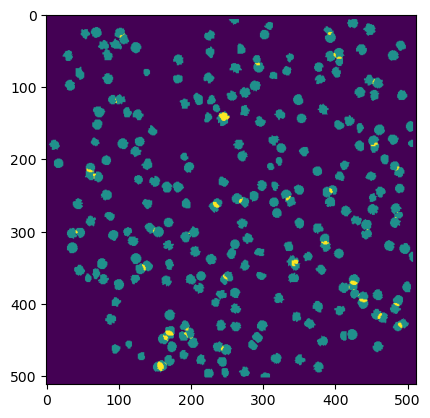

In [6]:
if not '.mat' in params_movie['seed_name'][0]:
    roi_cons = np.load(params_movie['seed_name'][0])
else:
    roi_cons = scipy.io.loadmat(params_movie['seed_name'][0])['comps'].reshape(
        (dims[1], dims[0], -1), order='F').transpose([2, 1, 0]) * 1.

radius = int(np.median(np.sqrt(np.sum(roi_cons, (1, 2)) / np.pi)))

print(radius)
print(roi_cons.shape)
plt.imshow(roi_cons.sum(0))

In [7]:
if params_movie['kernel'] is not None:  # kernel usually two
    kernel = np.ones(
        (radius // params_movie['kernel'], radius // params_movie['kernel']), np.uint8)
    roi_cons = np.vstack([cv2.dilate(rr, kernel, iterations=1)[
                         np.newaxis, :, :] > 0 for rr in roi_cons]) * 1.
    pl.imshow(roi_cons.sum(0), alpha=0.5)

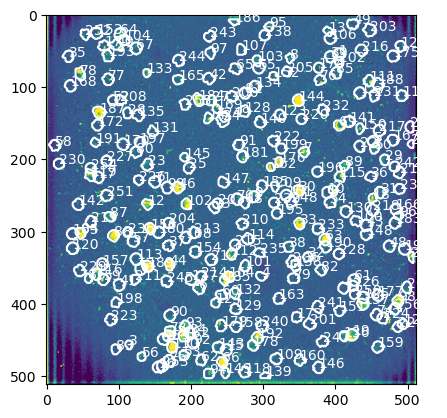

In [8]:
A_in = np.reshape(roi_cons.transpose(
    [2, 1, 0]), (-1, roi_cons.shape[0]), order='C')
plt.figure()
crd = plot_contours(A_in, Cn, thr=.99999)

### Parameter Setting

In [9]:
# order of the autoregressive fit to calcium imaging in general one (slow gcamps) or two (fast gcamps fast scanning)
p = params_movie['p']
# merging threshold, max correlation allowed
merge_thresh = params_movie['merge_thresh']

### Extract spatial and temporal components on patches

In [10]:
if images.shape[0] > 10000:
    check_nan = False
else:
    check_nan = True

cnm = cnmf.CNMF(check_nan=check_nan, n_processes=1, k=A_in.shape[-1], gSig=[radius, radius], merge_thresh=params_movie['merge_thresh'], p=params_movie['p'], Ain=A_in.astype(bool),
                dview=dview, rf=None, stride=None, gnb=params_movie['gnb'], method_deconvolution='oasis', border_pix=0, low_rank_background=params_movie['low_rank_background'], n_pixels_per_process=1000)

In [11]:
# Double check cnm object
cnm = cnm.fit(images)
print(cnm)

spatial support for each components given by the user


### Return CNM estimates

Number of components:256


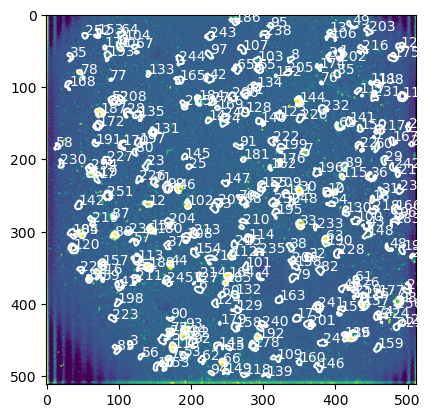

In [12]:
A = cnm.estimates.A #don't know how to process
C = cnm.estimates.C #don't know how to process
YrA = cnm.estimates.YrA

b = cnm.estimates.b
f = cnm.estimates.f
snt = cnm.estimates.sn
print(('Number of components:' + str(A.shape[-1])))
plt.figure()
crd = plot_contours(A, Cn, thr=params_display['thr_plot'])

### Threshold Components 

Component:0


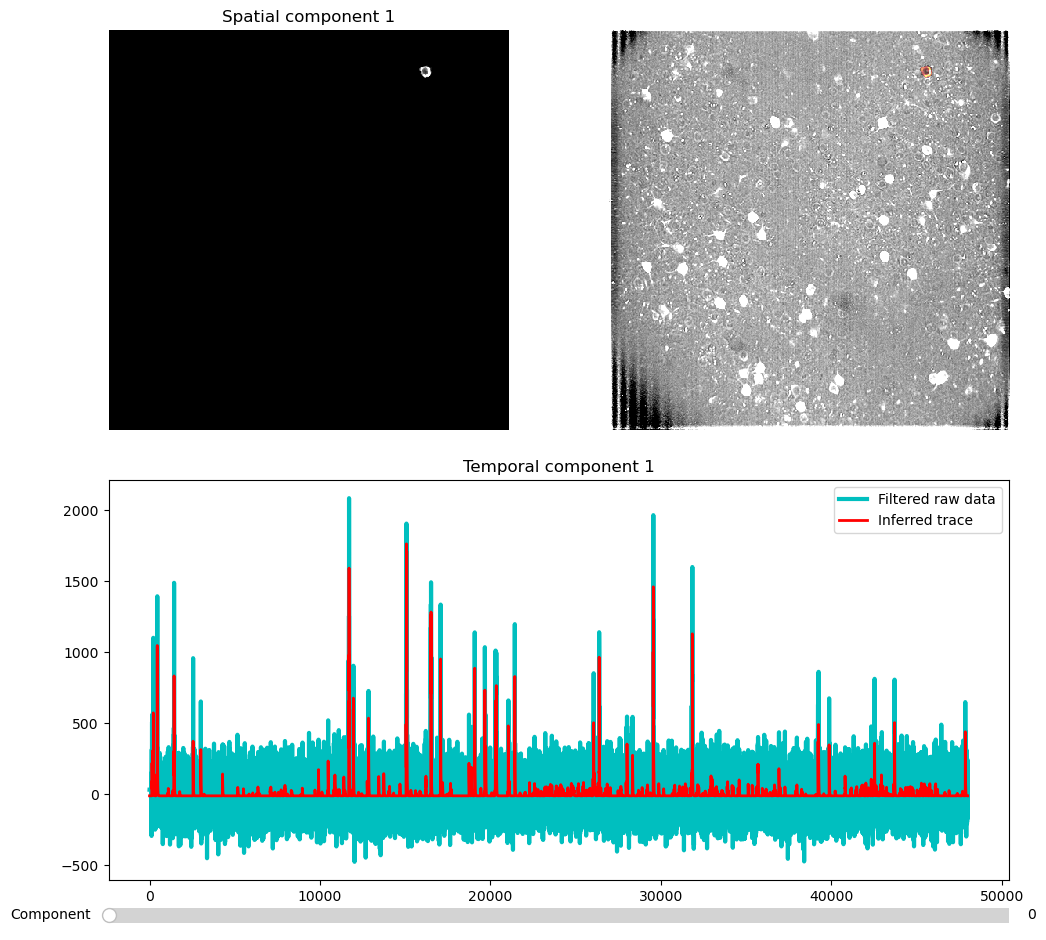

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


Exception: A cluster is already running. Terminate with dview.terminate() if you want to restart.

In [13]:
# TODO: needinfo
view_patches_bar(Yr, scipy.sparse.coo_matrix(A.tocsc()[:, :]), C[:, :], b, f, dims[0], dims[1],
                 YrA=YrA[:, :], img=Cn)

c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(262144, 253)


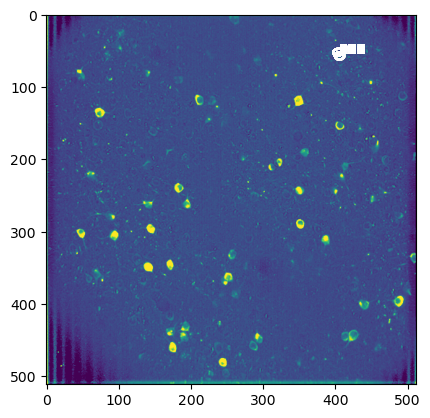

In [14]:
min_size_neuro = 3 * 2 * np.pi
max_size_neuro = (2 * radius)**2 * np.pi

A_thr = cm.source_extraction.cnmf.spatial.threshold_components(A.tocsc()[:, :].toarray(), dims, medw=None, thr_method='max', maxthr=0.2, nrgthr=0.99, extract_cc=True,
                                                               se=None, ss=None, dview=dview)

A_thr = A_thr > 0
size_neurons = A_thr.sum(0)
idx_size_neuro = np.where((size_neurons > min_size_neuro)
                          & (size_neurons < max_size_neuro))[0]
A_thr = A_thr[:, idx_size_neuro]
print(A_thr.shape)

crd = plot_contours(scipy.sparse.coo_matrix(
    A_thr * 1.), Cn, thr=.99, vmax=0.35)

(256, 512, 512)


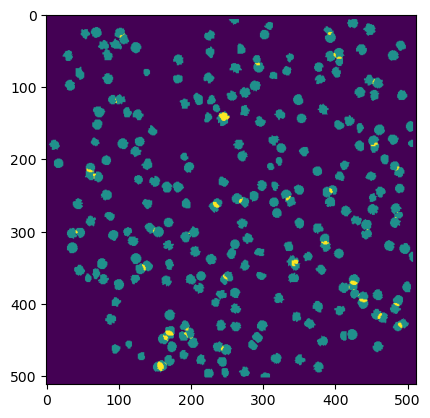

In [15]:
roi_cons = np.load(params_movie['gtname'][0])
print(roi_cons.shape)
plt.imshow(roi_cons.sum(0))

### Compare CNMF Seeded with ground truth

In [16]:
if hasattr(A_thr, "toarray"):
    A_thr = A_thr.toarray()
A_thr = np.array(A_thr)

plt.figure(figsize=(30, 20))


tp_gt, tp_comp, fn_gt, fp_comp, performance_cons_off = cm.base.rois.nf_match_neurons_in_binary_masks(masks_gt=roi_cons, 
                                                                               masks_comp=A_thr[:, :].reshape([dims[0], dims[1], -1], order='F').transpose([2, 0, 1]) * 1., 
                                                                               thresh_cost=.7, 
                                                                               min_dist=10,
                                                                               print_assignment=False, 
                                                                               plot_results=False, 
                                                                               Cn=Cn,  
                                                                               labels=['GT', 'Offline'])
plt.rcParams['pdf.fonttype'] = 42
font = {'family': 'Myriad Pro', 'weight': 'regular', 'size': 20}
plt.rc('font', **font)

<Figure size 3000x2000 with 0 Axes>

### Generating match_masks.npz

In [17]:
np.savez(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + 'match_masks_pytorch.npz'), 
         Cn=Cn,
         tp_gt=tp_gt, 
         tp_comp=tp_comp, 
         fn_gt=fn_gt, 
         fp_comp=fp_comp, 
         performance_cons_off=performance_cons_off, 
         idx_size_neuro_gt=idx_size_neuro, 
         A_thr=A_thr,
         A_gt=A, 
         C_gt=C, 
         b_gt=b, 
         f_gt=f, 
         YrA_gt=YrA, 
         d1=d1, 
         d2=d2, 
         idx_components_gt=idx_size_neuro[tp_comp],
         idx_components_bad_gt=idx_size_neuro[fp_comp], fname_new=fname_new)